In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nose.tools import *

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from sklearn.metrics import mean_absolute_error, mean_squared_error

# English Premier League Data Science Project 
## Analyzing a 12 year span in which the league boomed in terms of popularity.
## What makes a champion in the richest football league in the world?

### Introduction
On 27 May 1992 the Premier League was formed as a breakaway league from the original Football League. The main motivation was money - the TV deals and the distribution of the money will be more beneficial for the clubs in the Premier League. And as with all sports with money come coaches,players and the quality of the league increases, therefore its marketability. The datasets provided for you in the `data/` folder contain the following information:
- results.csv will tell the story about all the results in the PL between the 2006/07 season and the 2017/18 season.
- stats.csv will expand on the statistical categories that are official for the Premier League and that are going to be one of the main sources for a deeper analysis.
- EPL standings 2000-2022.csv will provide the standings of the individual teams throughout the seasons 2000-2022
- with_goalscorers.csv will provide the top goalscorers from the formation of the PL in 1992 until now.

Answering the question of this project will require the acquisition of data, tidying and exploring it,visualizing it, as well as preparing and modelling the data with linear regression.

The original datasets are located as follows :
- [results.csv and stats.csv](https://www.kaggle.com/datasets/zaeemnalla/premier-league)
- [EPL standings 2000-2022.csv](https://www.kaggle.com/datasets/quadeer15sh/premier-league-standings-11-seasons-20102021)
- [with_goalscorers.csv](https://fbref.com/en/comps/9/history/Premier-League-Seasons)

A word about the sources : 
- Kaggle is a subsidiary of Google and is the biggest community of data science and machine learning practitioners
- FBref is a major football statistics site and the company has similar sites for basketball and other sports.

You can read the pages for more information about the data and variables.

### Overiew of the datasets :
All data will be formatted up until from 06/07 until 17/18 season to unify the data timeframe.\
**results.csv** boasts the following columns: 
- home_team - The team that played at their own stadium
- away_team - the opposition of the home team
- home_goals - the goals scored by the home team 
- away_gols - the goals scored for the away team
- result - can hold 'H' which indicates a home win, 'D' which indicates a Draw and 'A' which indicates an away win
- season - specifies the season which the match occured in

**stats.csv** is a little trickier as it has 42 columns and you can check them out [here](https://www.kaggle.com/datasets/zaeemnalla/premier-league?select=stats.csv)

**standings.csv** has the following: 
- Season - the season for which the other data is for 
- Pos - the position in which the team finished in the standings
- Team - the name of the team
- Pld - the amount of games played in that year (constant 38)
- W - amount of games won
- D - amount of games drawn
- L - amount of games lost
- GF - goals for the team
- GA - goals against
- GD  - GF minus GA 
- Pts - points that the team has had in the season (3 pts for a win, 1 pt for a draw , 0 for a loss)
- Qualification or relegation - whether or not the team has qualified for a European competition during the season or has been relegated from the PL

**with_goalscorers.csv** has some repetitive columns but the one that concern us in this dataset is : 
- Top scorer - the name of the top goalscorer with the number being the goals scored and the text in the brackets is the team for which he scored them



## Reading the data

In [3]:
league_data = pd.read_csv("data/results.csv")
stats = pd.read_csv('data/stats.csv')
standings = pd.read_csv('data/EPL Standings 2000-2022.csv')
with_goalscorers = pd.read_csv('data/with_goalscorers.csv')

In [4]:
assert_is_not_none(league_data)
assert_is_not_none(stats)
assert_is_not_none(standings)
assert_is_not_none(with_goalscorers)

## Data tidying and exploration

### Data tidying

Now that we have read the data, let's see Chelsea's scores throughout the seasons.

In [5]:
league_data[league_data.home_team == 'Chelsea']

,home_team,away_team,home_goals,away_goals,result,season
9,Chelsea,Manchester City,3.0,0.0,H,2006-2007
31,Chelsea,Charlton Athletic,2.0,1.0,H,2006-2007
43,Chelsea,Liverpool,1.0,0.0,H,2006-2007
61,Chelsea,Aston Villa,1.0,1.0,D,2006-2007
81,Chelsea,Portsmouth,2.0,1.0,H,2006-2007
...,...,...,...,...,...,...
4476,Chelsea,Crystal Palace,2.0,1.0,H,2017-2018
4493,Chelsea,Tottenham Hotspur,1.0,3.0,A,2017-2018
4503,Chelsea,West Ham United,1.0,1.0,D,2017-2018
4543,Chelsea,Liverpool,1.0,0.0,H,2017-2018


In [6]:
league_data.dtypes

home_team      object
away_team      object
home_goals    float64
away_goals    float64
result         object
season         object
dtype: object

In [7]:
assert_equal(league_data.shape, (4560, 6))

Okay, we have read the data successfully and the data types look good we can head to the standings.\
Firstly, the data is not unified in terms of timeframe and we have to group the standings from 2006/07 until 2017/18.

In [8]:
new_standings = standings[standings['Season'].between('2006-07','2017-18')]

We have now unified the data timeframe and we can take a look at the champions of all the seasons we are observing.

In [9]:
new_standings[new_standings.Pos == 1]

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Qualification or relegation
120,2006-07,1,Manchester United,38,28,5,5,83,27,56,89,Qualification for the Champions League group s...
140,2007-08,1,Manchester United,38,27,6,5,80,22,58,87,Qualification for the Champions League group s...
160,2008-09,1,Manchester United,38,28,6,4,68,24,44,90,Qualification for the Champions League group s...
180,2009-10,1,Chelsea,38,27,5,6,103,32,71,86,Qualification for the Champions League group s...
200,2010-11,1,Manchester United,38,23,11,4,78,37,41,80,Qualification for the Champions League group s...
220,2011-12,1,Manchester City,38,28,5,5,93,29,64,89,Qualification for the Champions League group s...
240,2012-13,1,Manchester United,38,28,5,5,86,43,43,89,Qualification for the Champions League group s...
260,2013-14,1,Manchester City,38,27,5,6,102,37,65,86,Qualification for the Champions League group s...
280,2014-15,1,Chelsea,38,26,9,3,73,32,41,87,Qualification for the Champions League group s...
300,2015-16,1,Leicester City,38,23,12,3,68,36,32,81,Qualification for the Champions League group s...


In [10]:
new_standings.dtypes

Season                         object
Pos                             int64
Team                           object
Pld                             int64
W                               int64
D                               int64
L                               int64
GF                              int64
GA                              int64
GD                              int64
Pts                             int64
Qualification or relegation    object
dtype: object

In [11]:
new_standings.reset_index(drop=True,inplace=True)

We won't be looking into qualification for the European competitions or relegation to the second tier, therefore we can drop the Qualification or relegation column.

In [12]:
new_standings.drop('Qualification or relegation',axis=1,inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
new_standings

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
0,2006-07,1,Manchester United,38,28,5,5,83,27,56,89
1,2006-07,2,Chelsea,38,24,11,3,64,24,40,83
2,2006-07,3,Liverpool,38,20,8,10,57,27,30,68
3,2006-07,4,Arsenal,38,19,11,8,63,35,28,68
4,2006-07,5,Tottenham Hotspur,38,17,9,12,57,54,3,60
...,...,...,...,...,...,...,...,...,...,...,...
235,2017-18,16,Huddersfield Town,38,9,10,19,28,58,-30,37
236,2017-18,17,Southampton,38,7,15,16,37,56,-19,36
237,2017-18,18,Swansea City,38,8,9,21,28,56,-28,33
238,2017-18,19,Stoke City,38,7,12,19,35,68,-33,33


In [14]:
assert_equal(new_standings.shape, (240, 11))

Standings looking good! Let's move on to the goalscorers.

In [196]:
with_goalscorers

,Season,Competition Name,Champion,Top Scorer,Goals,Team
0,2022-2023,Premier League,NaN,Rodrigo,3,Leeds United
1,2021-2022,Premier League,Manchester City,Son Heung-min Mohamed Salah,23,Tottenham Hotspur Liverpool
2,2020-2021,Premier League,Manchester City,Harry Kane,23,Tottenham Hotspur
3,2019-2020,Premier League,Liverpool,Jamie Vardy,23,Leicester City
4,2018-2019,Premier League,Manchester City,Pierre-Emerick Aubameyang Sadio Mané...,22,Arsenal Liverpool
5,2017-2018,Premier League,Manchester City,Mohamed Salah,32,Liverpool
6,2016-2017,Premier League,Chelsea,Harry Kane,29,Tottenham
7,2015-2016,Premier League,Leicester City,Harry Kane,25,Tottenham
8,2014-2015,Premier League,Chelsea,Sergio Agüero,26,Manchester City
9,2013-2014,Premier League,Manchester City,Luis Suárez,31,Liverpool


Here we face two problems that need solving.\
Firstly, we don't like the column 'Top scorer' as it has too much information in it.We'd like to split some data from the Top scorer column like Goals and the Team that the player was playing for. \
Secondly, we need to unify the data in regards to time as this data is from the foundation of the PL until now.

Tackling the first problem, there is a '-' that separates the Top scorer from the Goals and Team. This allows us to split 'Top scorer' into two new columns - the name of the Top scorer in 'Top Scorer' and the amount of goals and the Team into a new column called 'Goals Team'.

In [15]:
with_goalscorers[['Top Scorer','Goals Team']] = with_goalscorers['Top Scorer'].str.split('- ',expand=True)
with_goalscorers

Now, we can see that the team is in brackets and to remove them and separate the two into new columns we split by the first '('. We create the new columns 'Goals' and 'Team'.

In [16]:
with_goalscorers[['Goals', 'Team']] = with_goalscorers['Goals Team'].str.split('(',expand=True)
with_goalscorers

We continue to face the brackets problem but this time its much easier to remove them because it is the last character in every row in the 'Team' column.

In [17]:
with_goalscorers['Team'] = with_goalscorers['Team'].str[:-1]
with_goalscorers

From this split we are close to being done with the first issue. However, we shouldn't forget that this operation created a 'Goals' column that was not an int but an object. We need to change that.

In [18]:
with_goalscorers.dtypes

Season              object
Competition Name    object
# Squads             int64
Champion            object
Top Scorer          object
Goals Team          object
Goals               object
Team                object
dtype: object

In [19]:
with_goalscorers.Goals = with_goalscorers.Goals.astype(int)

We drop the column that was needed to step-split the text and we are done with the first issue we were facing in this data.

In [20]:
with_goalscorers.drop('Goals Team',axis=1,inplace=True)

We can drop the number of squads in the PL because they don't change for the period that we are observing.

In [21]:
with_goalscorers.drop('# Squads',axis =1,inplace=True)

Now, we need to tackle the second issue which is to unify our data into one timeframe - 2006/07 until 2017/18

In [22]:
with_goalscorers_sorted = with_goalscorers[with_goalscorers.Season.between('2006-2007','2017-2018')]

In [23]:
assert_equal(with_goalscorers_sorted.shape, (12, 6))

We're done with the goalscorers, no we should tackle the big dataset - stats.\
Let's start by checking if there are any N/A values.

In [24]:
stats.isna().any()

team                    False
wins                    False
losses                  False
goals                   False
total_yel_card          False
total_red_card          False
total_scoring_att       False
ontarget_scoring_att    False
hit_woodwork            False
att_hd_goal             False
att_pen_goal            False
att_freekick_goal       False
att_ibox_goal           False
att_obox_goal           False
goal_fastbreak          False
total_offside           False
clean_sheet             False
goals_conceded          False
saves                    True
outfielder_block        False
interception            False
total_tackle            False
last_man_tackle         False
total_clearance         False
head_clearance           True
own_goals               False
penalty_conceded        False
pen_goals_conceded      False
total_pass              False
total_through_ball       True
total_long_balls        False
backward_pass            True
total_cross             False
corner_tak

Looking through the stats we can see that head_clearance, saves, dispossessed and total_through_ball have N/A values. The N/A's that we observe are for the 2006/2007 season when the PL didn't keep that metric but started counting it in the following seasons. Due to the nature of the data it won't work if we add the mean of the next season.\
Our research is not closesly linked with any of these variables, therefore we can drop them.

We make the observation that backward pass and big_chance_missed is being measured from 2009-10.\
Our research is not closely linked with either of the two therefore we can drop them along with the previously mentioned.

In [25]:
stats[stats.dispossessed.isna()] #example how N/A values were checked; how we made the observations above

,team,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,...,total_cross,corner_taken,touches,big_chance_missed,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches,season
0,Manchester United,28.0,5.0,83.0,60.0,1.0,698.0,256.0,21.0,12.0,...,918.0,258.0,25686.0,NaN,1.0,NaN,2.0,37.0,25.0,2006-2007
1,Chelsea,24.0,3.0,64.0,62.0,4.0,636.0,216.0,14.0,16.0,...,897.0,231.0,24010.0,NaN,2.0,NaN,1.0,74.0,22.0,2006-2007
2,Liverpool,20.0,10.0,57.0,44.0,0.0,668.0,214.0,15.0,8.0,...,1107.0,282.0,24150.0,NaN,1.0,NaN,0.0,51.0,27.0,2006-2007
3,Arsenal,19.0,8.0,63.0,59.0,3.0,638.0,226.0,19.0,10.0,...,873.0,278.0,25592.0,NaN,1.0,NaN,0.0,88.0,27.0,2006-2007
4,Tottenham Hotspur,17.0,12.0,57.0,48.0,3.0,520.0,184.0,6.0,5.0,...,796.0,181.0,22200.0,NaN,2.0,NaN,0.0,51.0,24.0,2006-2007
5,Bolton Wanderers,16.0,14.0,47.0,84.0,4.0,404.0,120.0,7.0,10.0,...,942.0,217.0,18932.0,NaN,6.0,NaN,2.0,44.0,21.0,2006-2007
6,Reading,16.0,15.0,52.0,38.0,3.0,419.0,132.0,8.0,15.0,...,1067.0,280.0,18017.0,NaN,2.0,NaN,0.0,63.0,21.0,2006-2007
7,Blackburn Rovers,15.0,16.0,52.0,77.0,6.0,478.0,155.0,5.0,12.0,...,911.0,205.0,20812.0,NaN,8.0,NaN,5.0,56.0,25.0,2006-2007
8,Everton,15.0,10.0,52.0,65.0,2.0,465.0,153.0,9.0,9.0,...,867.0,208.0,19250.0,NaN,2.0,NaN,1.0,83.0,15.0,2006-2007
9,Portsmouth,14.0,12.0,45.0,48.0,1.0,525.0,186.0,9.0,13.0,...,783.0,247.0,19377.0,NaN,4.0,NaN,2.0,79.0,30.0,2006-2007


In [26]:
stats.drop(['head_clearance','saves','dispossessed','total_through_ball','backward_pass','big_chance_missed'],axis=1,inplace=True)

In [27]:
assert_equal(stats.shape, (240, 36))

Obligatory check for N/A values in league_data.

In [28]:
league_data.isna().any()

home_team     False
away_team     False
home_goals    False
away_goals    False
result        False
season        False
dtype: bool

Earlier we looked at the champions during the observed period. Let's save that as a variable.

In [29]:
champions = new_standings[new_standings.Pos==1]

In [30]:
champions.reset_index(drop=True,inplace=True)

In [31]:
champions

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
0,2006-07,1,Manchester United,38,28,5,5,83,27,56,89
1,2007-08,1,Manchester United,38,27,6,5,80,22,58,87
2,2008-09,1,Manchester United,38,28,6,4,68,24,44,90
3,2009-10,1,Chelsea,38,27,5,6,103,32,71,86
4,2010-11,1,Manchester United,38,23,11,4,78,37,41,80
5,2011-12,1,Manchester City,38,28,5,5,93,29,64,89
6,2012-13,1,Manchester United,38,28,5,5,86,43,43,89
7,2013-14,1,Manchester City,38,27,5,6,102,37,65,86
8,2014-15,1,Chelsea,38,26,9,3,73,32,41,87
9,2015-16,1,Leicester City,38,23,12,3,68,36,32,81


In [32]:
with_goalscorers_sorted

,Season,Competition Name,Champion,Top Scorer,Goals,Team
5,2017-2018,Premier League,Manchester City,Mohamed Salah,32,Liverpool
6,2016-2017,Premier League,Chelsea,Harry Kane,29,Tottenham
7,2015-2016,Premier League,Leicester City,Harry Kane,25,Tottenham
8,2014-2015,Premier League,Chelsea,Sergio Agüero,26,Manchester City
9,2013-2014,Premier League,Manchester City,Luis Suárez,31,Liverpool
10,2012-2013,Premier League,Manchester United,Robin van Persie,26,Manchester United
11,2011-2012,Premier League,Manchester City,Robin van Persie,30,Arsenal
12,2010-2011,Premier League,Manchester United,Dimitar Berbatov Carlos Tevez,20,Manchester United Manchester City
13,2009-2010,Premier League,Chelsea,Didier Drogba,29,Chelsea
14,2008-2009,Premier League,Manchester United,Nicolas Anelka,19,Chelsea


There is an issue here with the 'Season' column as it is not in the format that the "other" seasons are in.\
We are going to correct that with the following.

In [33]:
for i in range(len(champions.Season)):
    old = champions.Season[i]
    new = old[:5]+'20'+old[5:]
    champions.Season[i]= new

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


We have formatted the Season column so its unified with the others in the format '20ab-20cd'.

In [34]:
assert_equal(champions.shape, (12, 11))
assert_is_not_none(champions)
assert_is_not_none(stats)
assert_is_not_none(with_goalscorers_sorted)
assert_is_not_none(league_data)
assert_is_not_none(new_standings)
assert_equal(with_goalscorers_sorted.columns.tolist(), ['Season', 'Competition Name', 'Champion', 'Top Scorer', 'Goals','Team'])

### Exploratory Data Analysis (EDA)

Our data is looking good and we can start with some EDA.\
What questions come to mind?

Which team scored the most goals in one season during these 11 seasons?

In [35]:
stats.loc[stats.goals.idxmax()][['team','goals','season']]

team      Manchester City
goals                 106
season          2017-2018
Name: 220, dtype: object

Manchester City scored 106 goals during the 2017-18 season in which, as we will see in the below code, they also became champions


Which team scored the most goals and didn't become champion?

Firstly, we need to get all teams throughout the seasons which didn't become champions.

In [36]:
non_champions = new_standings[new_standings.Pos!=1]
non_champions.reset_index(drop=True,inplace=True)

Then we sort by the goals scored to answer our question and we make it a top 10 for clarity.

In [37]:
non_champions.nlargest(10,'GF')

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
133,2013-14,2,Liverpool,38,26,6,6,101,50,51,84
95,2011-12,2,Manchester United,38,28,5,5,89,33,56,89
57,2009-10,2,Manchester United,38,27,4,7,86,28,58,85
190,2016-17,2,Tottenham Hotspur,38,26,8,4,86,26,60,86
211,2017-18,4,Liverpool,38,21,12,5,84,38,46,75
58,2009-10,3,Arsenal,38,23,6,9,83,41,42,75
152,2014-15,2,Manchester City,38,24,7,7,83,38,45,79
191,2016-17,3,Manchester City,38,23,9,6,80,39,41,78
192,2016-17,4,Liverpool,38,22,10,6,78,42,36,76
38,2008-09,2,Liverpool,38,25,11,2,77,27,50,86


Wow! Liverpool scored a whopping 101 goals during the 2013-14 season but still didn't become champions!\
Let's find how many teams became champions with less goals scored that Liverpool in 13-14.

In [38]:
champions_scored_less_liverpool = champions[champions.GF<non_champions.GF.max()]
champions_scored_less_liverpool.shape

(9, 11)

Out of 12 seasons only 3 title-winning teams managed to score more goals than Liverpool in the 13-14 in which they didn't even win the title! \
Here's who they are.

In [39]:
champions[champions.GF>non_champions.GF.max()]

,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
3,2009-2010,1,Chelsea,38,27,5,6,103,32,71,86
7,2013-2014,1,Manchester City,38,27,5,6,102,37,65,86
11,2017-2018,1,Manchester City,38,32,4,2,106,27,79,100


We observe that in that season(13-14) Manchester City scored 1 more goal and had more points.\
We can imply that not only goals is what matters to win a title, since, Liverpool have had more goals than 9 of the observed 12 champions. \
Maybe there are some other significant factors...

Let's take a look at another interesting questions regarding goals scored and wins.

How many times a team has won the title with them having the single top goalscorer?

To answer this question we first need to sort the goalscorers by season.

In [40]:
with_goalscorers_sorted.sort_values(by = 'Season',inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
with_goalscorers_sorted.reset_index(drop=True, inplace=True)

In [42]:
with_goalscorers_sorted

,Season,Competition Name,Champion,Top Scorer,Goals,Team
0,2006-2007,FA Premier League,Manchester United,Didier Drogba,20,Chelsea
1,2007-2008,Premier League,Manchester United,Cristiano Ronaldo,31,Manchester United
2,2008-2009,Premier League,Manchester United,Nicolas Anelka,19,Chelsea
3,2009-2010,Premier League,Chelsea,Didier Drogba,29,Chelsea
4,2010-2011,Premier League,Manchester United,Dimitar Berbatov Carlos Tevez,20,Manchester United Manchester City
5,2011-2012,Premier League,Manchester City,Robin van Persie,30,Arsenal
6,2012-2013,Premier League,Manchester United,Robin van Persie,26,Manchester United
7,2013-2014,Premier League,Manchester City,Luis Suárez,31,Liverpool
8,2014-2015,Premier League,Chelsea,Sergio Agüero,26,Manchester City
9,2015-2016,Premier League,Leicester City,Harry Kane,25,Tottenham


There is one season in which two players had the same amount of games and goals.(10-11)\
We can split the data into Top scorer 1,Top scorer 2,etc but that will generate a lot of N/A values.\
We like a single top goalscorer since that illustrates the supremacy of that player during that season better.\
Let's find out when the champions had the top goalscorer.

In [43]:
goalscorer_champions = with_goalscorers_sorted[with_goalscorers_sorted.Champion==with_goalscorers_sorted.Team]

In [44]:
goalscorer_champions

,Season,Competition Name,Champion,Top Scorer,Goals,Team
1,2007-2008,Premier League,Manchester United,Cristiano Ronaldo,31,Manchester United
3,2009-2010,Premier League,Chelsea,Didier Drogba,29,Chelsea
6,2012-2013,Premier League,Manchester United,Robin van Persie,26,Manchester United


Quite surpising results. Only 3 teams that were champions had the single top goalscorer.Let's calculate the percentage of that.

In [45]:
percentage_tg_ch = len(goalscorer_champions) / len(with_goalscorers_sorted)*100

In [46]:
print(f'{percentage_tg_ch} %')

25.0 %


Only 25% of the champions have the single top goalscorer! A possible reason is one team being over reliant on one player to carry the load and typically lack in other areas of the pitch, therefore the team isn't balanced enough to win it all.


What is the margin of victory for every champion in that period?

To answer that, we need to find all the second placed teams during the period in question.

In [47]:
second_placed = new_standings[new_standings.Pos==2]
second_placed.reset_index(drop=True,inplace=True)

We will also find out the third placed teams for further analysis.

In [162]:
third_placed = new_standings[new_standings.Pos==3]
third_placed.reset_index(drop=True,inplace=True)

We shall use the below to calculate the point differential.

In [48]:
winning_margin=champions.Pts-second_placed.Pts

We'll add the winning margin of every champion as a column in the champions dataframe.

In [49]:
champions['Winning_margin'] = winning_margin
champions

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Season,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,Winning_margin
0,2006-2007,1,Manchester United,38,28,5,5,83,27,56,89,6
1,2007-2008,1,Manchester United,38,27,6,5,80,22,58,87,2
2,2008-2009,1,Manchester United,38,28,6,4,68,24,44,90,4
3,2009-2010,1,Chelsea,38,27,5,6,103,32,71,86,1
4,2010-2011,1,Manchester United,38,23,11,4,78,37,41,80,9
5,2011-2012,1,Manchester City,38,28,5,5,93,29,64,89,0
6,2012-2013,1,Manchester United,38,28,5,5,86,43,43,89,11
7,2013-2014,1,Manchester City,38,27,5,6,102,37,65,86,2
8,2014-2015,1,Chelsea,38,26,9,3,73,32,41,87,8
9,2015-2016,1,Leicester City,38,23,12,3,68,36,32,81,10


We notice that Manchester City had a bit of a wild season, the last season of our observation period, winning the league with 19 points or nearly 7 games to spare. \
We also see that Manchester City again won on goal difference (GD) in the year 2011-12 because their winning margin is zero. \
This data is interesting, let's try some plots.

In [50]:
assert_is_not_none(non_champions)
assert_is_not_none(goalscorer_champions)
assert_equal(champions_scored_less_liverpool.shape, (9, 11))
assert_is_not_none(second_placed)
assert_is_not_none(percentage_tg_ch)
assert_is_not_none(champions_scored_less_liverpool)
assert_is_not_none(league_data)
assert_is_not_none(new_standings)
assert_is_not_none(winning_margin)

# Plots

Let's start with a winning margin line plot.

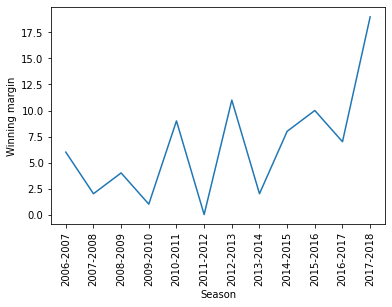

In [51]:
plt.plot(champions.Season,champions.Winning_margin)
plt.xlabel('Season')
plt.ylabel('Winning margin')
plt.xticks(rotation=90)
plt.show()

This shows us just how much of an outlier this last Man City season is. Also the league seems to adjust to every dominating team. \
We notice that after one dominating season, a season with a very small winning margin follows for the eventual champion. The rest of the league catches up.

Let's create a bar chart to visualize the amount of games each champion wins and how that is different to the runner up and the third placed teams.

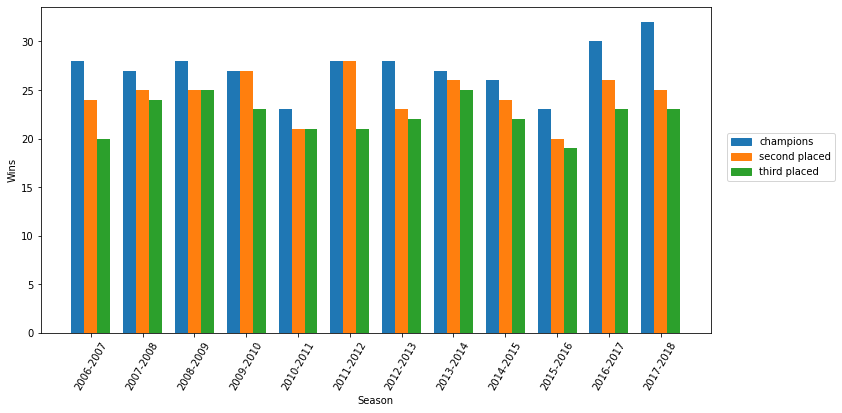

In [195]:
barWidth=0.25
fig = plt.subplots(figsize =(12, 6))

br1 = np.arange(len(champions.W))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


plt.bar(br1,champions.W,width = barWidth)
plt.bar(br2,second_placed.W,width = barWidth)
plt.bar(br3,third_placed.W,width = barWidth)


plt.xlabel('Season')
plt.ylabel('Wins')
plt.xticks([r + barWidth for r in range(len(champions.W))],
        champions.Season.tolist())
plt.xticks(rotation =60)
colors = {'champions':'tab:blue', 'second placed':'tab:orange', 'third placed':'tab:green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels,bbox_to_anchor=(1.05, 0.6),
           bbox_transform=plt.gcf().transFigure)
plt.show()

We can see the league was really competitive in terms of wins over the three year period between 2009-10 and 2011-12 where the total amount of win difference is very small in comparison to the other seasons.
Those were probably the most watched seasons as parity generates viewership.\
Another observation is the difference in wins between the first three teams during the period of 2013-14 until 2015-16.
It looks similar and the differences are pretty narrow and then they balloon over the next few seasons.
This may be attributed to the arrival of some of Europe's best managers - Jurgen Klopp at Liverpool and Pep Guardiola at Manchester City. They have dominated the league ever since.

Mentioning domination, which teams actually won the league the most during this timespan?

To answer the question we neeed to count how many times a team has won the title.

In [53]:
times_champion = champions.Team.value_counts()
teams = times_champion.index.to_list()

Let's plot a pie chart with the percentages of title wins and the team colors of every team.\
(Sorry Leicester fans, there's just too much blue in there that's why you're in your away colors.)

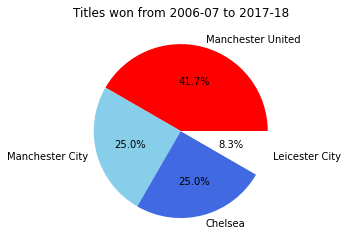

In [54]:
plt.pie(times_champion,
    labels = teams,
    autopct ='%1.1f%%',
    colors = ['red','skyblue','royalblue','white'])
plt.title('Titles won from 2006-07 to 2017-18')
plt.show()

Manchester United's dominance is quite noticeable but we have seen that it hasn't continued since 12-13.\
Possible reason for that is the retirement of their legendary manager sir Alex Ferguson

On the field, what makes a champion? Especially as dominant as Man United.\
Barring the obvious which is goals can we make any other assumptions regarding what influences wins? \
Can we interpret some of the football philosophies played in the English game and which is more successful?

Let's look at the correlations of all the stats data that we have for that period of time.

In [55]:
stats.corr()

,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,att_pen_goal,...,pen_goals_conceded,total_pass,total_long_balls,total_cross,corner_taken,touches,clearance_off_line,penalty_save,total_high_claim,punches
wins,1.000000,-0.890199,0.899236,-0.211276,-0.084818,0.753944,0.825577,0.512426,0.354752,0.398314,...,-0.299222,0.701707,-0.228135,0.208196,0.702131,0.704645,-0.316998,-0.032365,-0.162252,0.007351
losses,-0.890199,1.000000,-0.825820,0.235155,0.116112,-0.710323,-0.775273,-0.490826,-0.373599,-0.379356,...,0.313923,-0.646837,0.204358,-0.226708,-0.673469,-0.656575,0.293553,0.017236,0.147711,-0.010721
goals,0.899236,-0.825820,1.000000,-0.235392,-0.084373,0.788062,0.882988,0.564536,0.442670,0.492004,...,-0.258272,0.730479,-0.275572,0.216077,0.737691,0.733838,-0.268003,-0.000698,-0.222321,0.017450
total_yel_card,-0.211276,0.235155,-0.235392,1.000000,0.033770,-0.253648,-0.265842,-0.128863,-0.089670,-0.095150,...,0.171979,-0.216048,0.137093,-0.144025,-0.240047,-0.246781,-0.047345,-0.014418,0.094843,-0.073962
total_red_card,-0.084818,0.116112,-0.084373,0.033770,1.000000,-0.028250,-0.094543,-0.127432,-0.014242,0.038967,...,0.174909,-0.107723,-0.116108,0.020976,-0.090034,-0.067673,0.112337,0.062797,0.037623,0.089275
total_scoring_att,0.753944,-0.710323,0.788062,-0.253648,-0.028250,1.000000,0.938888,0.605026,0.271458,0.353282,...,-0.281627,0.642285,-0.335641,0.363540,0.794554,0.711154,-0.174188,-0.003246,-0.101241,0.138381
ontarget_scoring_att,0.825577,-0.775273,0.882988,-0.265842,-0.094543,0.938888,1.000000,0.626005,0.311790,0.395763,...,-0.279921,0.732246,-0.341806,0.257334,0.786692,0.767850,-0.225950,-0.005862,-0.166715,0.096687
hit_woodwork,0.512426,-0.490826,0.564536,-0.128863,-0.127432,0.605026,0.626005,1.000000,0.236210,0.191067,...,-0.220844,0.529739,-0.227261,0.170618,0.536658,0.531672,-0.128247,0.042172,-0.178729,-0.049829
att_hd_goal,0.354752,-0.373599,0.442670,-0.089670,-0.014242,0.271458,0.311790,0.236210,1.000000,0.132276,...,-0.062554,0.170387,-0.037376,0.299689,0.296625,0.173216,-0.075413,0.017676,-0.048019,-0.115129
att_pen_goal,0.398314,-0.379356,0.492004,-0.095150,0.038967,0.353282,0.395763,0.191067,0.132276,1.000000,...,-0.166240,0.233146,-0.105929,0.056393,0.332663,0.244434,-0.094283,0.020114,-0.017222,0.127869


Thats a lot of data! We can't even visualize the full tables but the one we are interested in is wins.
What influences them?\
There are some high enough positive correlations which are interesting to explore.\
The ones I have selected for the purpose of this analysis are touches, passes and clean sheets.\
There are two philosophies in football in general terms - attacking and defensive football.\
Defensive football in England is typically associated with sitting on defence and trying your best with crosses and long balls.The "XIX century" football.\
Attacking football is associated with more posession and more passes - touches and passes in our table.\
More often than not the really defensive teams don't keep a clean sheet as they are sitting deep and don't enjoy a lot of posession.\
We can see that some metrics that imply defensive football have a negative correlation with wins - like total long balls. Total crosses has a positive correlation but not nearly as strong as needed - 0.21.\
Attacking football is associated with passes and touches as well as typically clean sheets - for good teams - "Defence wins championships". That doesn't mean that the really defensive teams are gonna win but it means that attacking teams must keep their composure at the back.\
Lets visualize those variables with scatter plots first and then we will construct some Linear regression models.

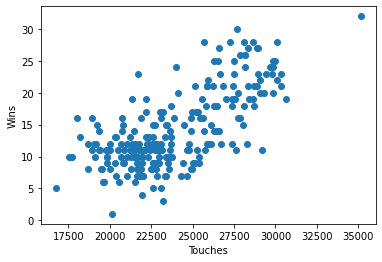

In [56]:
plt.scatter(stats.touches, stats.wins)
plt.xlabel('Touches')
plt.ylabel('Wins')
plt.show()

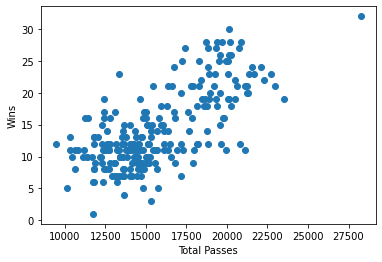

In [57]:
plt.scatter(stats.total_pass, stats.wins)
plt.xlabel('Total Passes')
plt.ylabel('Wins')
plt.show()

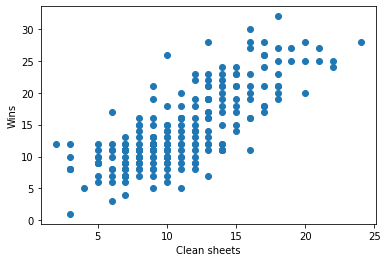

In [58]:
plt.scatter(stats.clean_sheet, stats.wins)
plt.xlabel('Clean sheets')
plt.ylabel('Wins')
plt.show()

We observe strong positive correlations with all scatter plots.\
What would be the best line that fits in each and every one of those models?
Let's find out!


# Modelling

To start we will need to do some pre-processing.\
We need to set arrays for both variables - the independent and dependent.\
We also need them to be in 2D arrays so our linear regression could work.\
And since we want to predict the wins based on the amount of touches - y will be our 'wins' column and X will be our 'touches' column.

In [59]:
y = stats['wins'].values.reshape(-1, 1)
X = stats['touches'].values.reshape(-1, 1)

In [60]:
print(stats['touches'].values)
print(stats['touches'].values.shape)

[25686. 24010. 24150. 25592. 22200. 18932. 18017. 20812. 19250. 19377.
 19199. 20040. 20002. 19378. 21213. 17713. 17564. 19497. 18720. 16772.
 26620. 26290. 28156. 25857. 21360. 20734. 21907. 22599. 23416. 22347.
 22761. 21415. 24679. 21064. 19140. 19855. 20846. 19541. 21259. 20140.
 30077. 29962. 29875. 29877. 23020. 25205. 26120. 26306. 26576. 25662.
 18693. 23071. 20876. 23450. 25414. 24442. 21712. 24904. 23322. 24327.
 28914. 28968. 29807. 25855. 28704. 26446. 23210. 24914. 23678. 21245.
 26134. 19825. 22903. 21587. 25000. 22641. 23571. 24973. 23416. 21522.
 26671. 27426. 25892. 28629. 24941. 25438. 22628. 18195. 22681. 21351.
 22628. 22224. 19421. 24796. 22108. 22772. 23616. 23517. 21652. 21823.
 28620. 28113. 28338. 27761. 22210. 26276. 22706. 24891. 26450. 22205.
 22830. 28300. 18936. 21770. 22943. 21694. 21309. 20036. 21017. 22585.
 27264. 27525. 25959. 28862. 25155. 23854. 27722. 21491. 20669. 24744.
 23005. 27641. 22314. 20675. 25365. 19830. 20782. 25173. 19613. 21941.
 28341

In [61]:
print(X.shape)
print(X)  

(240, 1)
[[25686.]
 [24010.]
 [24150.]
 [25592.]
 [22200.]
 [18932.]
 [18017.]
 [20812.]
 [19250.]
 [19377.]
 [19199.]
 [20040.]
 [20002.]
 [19378.]
 [21213.]
 [17713.]
 [17564.]
 [19497.]
 [18720.]
 [16772.]
 [26620.]
 [26290.]
 [28156.]
 [25857.]
 [21360.]
 [20734.]
 [21907.]
 [22599.]
 [23416.]
 [22347.]
 [22761.]
 [21415.]
 [24679.]
 [21064.]
 [19140.]
 [19855.]
 [20846.]
 [19541.]
 [21259.]
 [20140.]
 [30077.]
 [29962.]
 [29875.]
 [29877.]
 [23020.]
 [25205.]
 [26120.]
 [26306.]
 [26576.]
 [25662.]
 [18693.]
 [23071.]
 [20876.]
 [23450.]
 [25414.]
 [24442.]
 [21712.]
 [24904.]
 [23322.]
 [24327.]
 [28914.]
 [28968.]
 [29807.]
 [25855.]
 [28704.]
 [26446.]
 [23210.]
 [24914.]
 [23678.]
 [21245.]
 [26134.]
 [19825.]
 [22903.]
 [21587.]
 [25000.]
 [22641.]
 [23571.]
 [24973.]
 [23416.]
 [21522.]
 [26671.]
 [27426.]
 [25892.]
 [28629.]
 [24941.]
 [25438.]
 [22628.]
 [18195.]
 [22681.]
 [21351.]
 [22628.]
 [22224.]
 [19421.]
 [24796.]
 [22108.]
 [22772.]
 [23616.]
 [23517.]
 [21652.]
 

You can see the difference between a 1D array and a 2D array. We need a 2D array because our LinearRegression class requires it and it doesn't really change what we're doing.

We can model X and y straight away but how would we know if we're correct?\
We will need to split our model into two sections - the train section and the test section.\
We can use train_test_split for that.\
Because, it always operates randomly we need to set a random state so we get the same "random" test split.

In [62]:
Seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=Seed)

Let's perform the eye check.

In [63]:
print(X_train)
print(y_train)

[[21941.]
 [28914.]
 [30071.]
 [27890.]
 [24801.]
 [21861.]
 [30324.]
 [21051.]
 [21694.]
 [23067.]
 [21587.]
 [20782.]
 [22772.]
 [27722.]
 [27264.]
 [24914.]
 [28113.]
 [23678.]
 [26450.]
 [24941.]
 [20036.]
 [25741.]
 [21907.]
 [28300.]
 [22347.]
 [25155.]
 [22641.]
 [25892.]
 [18932.]
 [21712.]
 [27495.]
 [22866.]
 [23517.]
 [26446.]
 [19042.]
 [21533.]
 [26541.]
 [21415.]
 [20002.]
 [19855.]
 [23416.]
 [29875.]
 [28728.]
 [28030.]
 [29652.]
 [23071.]
 [25173.]
 [25989.]
 [23571.]
 [29962.]
 [29045.]
 [27367.]
 [23416.]
 [28172.]
 [21907.]
 [22434.]
 [22087.]
 [20368.]
 [22314.]
 [25686.]
 [24150.]
 [24973.]
 [26120.]
 [28620.]
 [22585.]
 [26857.]
 [21820.]
 [22628.]
 [25438.]
 [25645.]
 [22018.]
 [21652.]
 [20846.]
 [28341.]
 [28968.]
 [28156.]
 [21017.]
 [21922.]
 [22993.]
 [21064.]
 [20040.]
 [21668.]
 [22599.]
 [24484.]
 [22200.]
 [25959.]
 [24679.]
 [19613.]
 [26729.]
 [29807.]
 [19830.]
 [20669.]
 [21547.]
 [21710.]
 [26134.]
 [27542.]
 [28704.]
 [23020.]
 [22985.]
 [30077.]


Okay,all set. Now we need a regressor - in our case we want to conduct a linear regression so we are using LinearRegression() from sklearn.

In [64]:
regressor = LinearRegression()

Now we need to fit the line to our training data. Barring no errors we shall get a single output - LinearRegression()

In [65]:
regressor.fit(X_train, y_train)

LinearRegression()

Great! Now let's find out our intercept.

In [66]:
print(regressor.intercept_)

[-19.30936389]


Let's also find out the slope of our line.

In [67]:
print(regressor.coef_)

[[0.00139209]]


This model has shown us that every touch improves the wins by 0.01%. Thats realistic because teams touch the ball a lot during football games. Lets calculate how many wins would 30000 touches yield.\
We can use a calc function which receives our slope, intercept and our independent variable.\
We are using the basic linear regression formula ax+b.
Let's see the results!

In [68]:
def calc(slope, intercept, indep_var):
    return slope*indep_var+intercept

wins = calc(regressor.coef_, regressor.intercept_, 30000)
print(wins)

[[22.45339787]]


Can we trust this figure though? Thats why we did train_test_split so we can check the model and see how well it predicts the values that we have already observed.

Let's pass our depedent test variable to the predict method and call it y_pred.

In [69]:
y_pred = regressor.predict(X_test)

Now let's create a new dataframe to compare the results!

In [70]:
actual_predicted = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
print(actual_predicted)

    Actual  Predicted
0     19.0  10.425722
1     16.0   5.771959
2     11.0  15.208951
3     13.0  11.602040
4     19.0  11.609001
5     11.0  10.686044
6     10.0  11.216431
7     13.0  12.190895
8     14.0   7.665204
9     24.0  22.209782
10    17.0  15.778316
11    17.0  15.923094
12    11.0  12.629404
13    15.0  13.303177
14    11.0  10.996480
15    11.0  13.591340
16    18.0  13.705491
17    10.0   5.348763
18    11.0   9.243836
19    16.0  13.897600
20    14.0  10.608087
21     5.0   4.038804
22     9.0  12.178366
23    11.0  12.376043
24     8.0  11.962592
25    13.0  13.159791
26    12.0   7.417412
27    26.0  19.878028
28     7.0  14.990392
29    10.0  10.555187
30    10.0  13.566282
31    12.0  12.388572
32    16.0   9.554273
33    19.0  20.220482
34     8.0   6.750599
35    13.0  10.265632
36    11.0  15.898036
37     9.0  14.716150
38     6.0  10.651241
39    10.0  13.230788
40    13.0  11.731505
41    11.0   7.051291
42    25.0  19.007970
43    10.0   5.141341
44     9.0

We can see that the model isn't entirely accurate. We can evaluate the model in four different ways:
- Mean Absolute Error
- Mean Squared Error
- Root Mean Squared Error
- .score on the model or R Squared

Let's calculate those with the help of sklearn.

In [71]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [72]:
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 3.25
Mean squared error: 16.39
Root mean squared error: 4.05


The closest these values are to zero, the more accurate is the model. 
The last one RMSE shows that we are missing the value with 4.05 at the most - thats 4.05 lower or higher.
In the case of wins thats a significant amount but considering the data we have and the fact that 38 games are played in a season it's passable.\
Let's check R squared.

In [73]:
regressor.score(X_test, y_test)

0.24098908746757786

Our model is not the most accurate but that was expected considering the data. Let's try to plot it in the scatters we saw earlier.

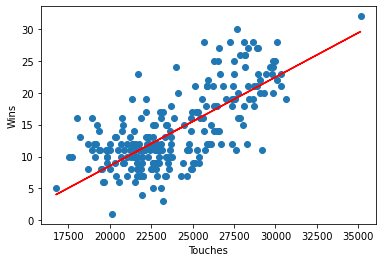

In [74]:
plt.scatter(X,y)
plt.plot(X, regressor.coef_*X+regressor.intercept_,color='red')
plt.xlabel('Touches')
plt.ylabel('Wins')
plt.show()

In [75]:
assert_is_not_none(X)
assert_is_not_none(y)
assert_is_not_none(regressor)
assert_is_not_none(mae)
assert_is_not_none(mse)
assert_is_not_none(rmse)
assert_is_not_none(y_pred)
assert_greater(regressor.score(X_test, y_test), 0)
assert_less_equal(regressor.score(X_test, y_test), 1)

Now let's try with the other variable that has a high correlation to wins - passes

In [76]:
y1 = stats['wins'].values.reshape(-1, 1)
X1= stats['total_pass'].values.reshape(-1, 1)

In [77]:
print(stats['total_pass'].values)
print(stats['total_pass'].shape)

[18723. 16759. 17154. 18458. 14914. 12400. 11232. 14033. 12274. 12616.
 12779. 13178. 13254. 12765. 14628. 11123. 11353. 12722. 11820. 10175.
 17422. 17252. 18831. 16360. 12397. 11438. 12794. 13650. 15149. 13773.
 13947. 12727. 15466. 12200. 10431. 11684. 11854. 10630. 12576. 11739.
 19416. 19923. 19505. 18991. 12419. 15024. 15971. 16100. 15723. 15316.
  9478. 12319. 10649. 13436. 14497. 14144. 11809. 14518. 13124. 14172.
 18852. 19318. 19291. 15474. 18575. 16323. 13127. 14832. 13540. 11792.
 16505. 10307. 12489. 11404. 14753. 13020. 13591. 14616. 13509. 11731.
 18870. 19236. 17768. 20150. 16728. 16791. 14371. 10349. 14611. 12704.
 14166. 14252. 11178. 16345. 14194. 14823. 15113. 15180. 14036. 13367.
 20863. 20184. 20599. 19564. 14638. 18766. 15063. 17669. 18797. 14691.
 15165. 20795. 10831. 13913. 15715. 13580. 13383. 12424. 13158. 14860.
 19696. 20061. 18425. 21110. 16647. 15829. 19802. 14367. 12582. 16940.
 14599. 19943. 14247. 13403. 16810. 12287. 13109. 17927. 11806. 13632.
 20761

In [78]:
Seed = 42
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state=Seed)

In [79]:
print(X1_train)

[[13632.]
 [18852.]
 [22290.]
 [19733.]
 [17152.]
 [13785.]
 [22962.]
 [13671.]
 [13580.]
 [15736.]
 [11404.]
 [13109.]
 [14823.]
 [19802.]
 [19696.]
 [14832.]
 [20184.]
 [13540.]
 [18797.]
 [16728.]
 [12424.]
 [17947.]
 [13659.]
 [20795.]
 [13773.]
 [16647.]
 [13020.]
 [17768.]
 [12400.]
 [11809.]
 [19322.]
 [14704.]
 [15180.]
 [16323.]
 [11825.]
 [13542.]
 [18266.]
 [12727.]
 [13254.]
 [11684.]
 [15149.]
 [19505.]
 [21264.]
 [19577.]
 [22107.]
 [12319.]
 [17927.]
 [18169.]
 [13591.]
 [19923.]
 [20527.]
 [18894.]
 [13509.]
 [19599.]
 [12794.]
 [14372.]
 [14558.]
 [12892.]
 [14247.]
 [18723.]
 [17154.]
 [14616.]
 [15971.]
 [20863.]
 [14860.]
 [18301.]
 [14445.]
 [14166.]
 [16791.]
 [17877.]
 [14007.]
 [14036.]
 [11854.]
 [20761.]
 [19318.]
 [18831.]
 [13158.]
 [14457.]
 [15118.]
 [12200.]
 [13178.]
 [14675.]
 [13650.]
 [16087.]
 [14914.]
 [18425.]
 [15466.]
 [11806.]
 [18809.]
 [19291.]
 [12287.]
 [12582.]
 [14049.]
 [13370.]
 [16505.]
 [20070.]
 [18575.]
 [12419.]
 [15267.]
 [19416.]


In [80]:
print(y1_test)

[[19.]
 [16.]
 [11.]
 [13.]
 [19.]
 [11.]
 [10.]
 [13.]
 [14.]
 [24.]
 [17.]
 [17.]
 [11.]
 [15.]
 [11.]
 [11.]
 [18.]
 [10.]
 [11.]
 [16.]
 [14.]
 [ 5.]
 [ 9.]
 [11.]
 [ 8.]
 [13.]
 [12.]
 [26.]
 [ 7.]
 [10.]
 [10.]
 [12.]
 [16.]
 [19.]
 [ 8.]
 [13.]
 [11.]
 [ 9.]
 [ 6.]
 [10.]
 [13.]
 [11.]
 [25.]
 [10.]
 [ 9.]
 [17.]
 [18.]
 [ 8.]]


In [81]:
regressor1 = regressor

In [82]:
regressor1.fit(X1_train,y1_train)

LinearRegression()

In [83]:
print(regressor1.coef_)

[[0.00138629]]


In [84]:
print(regressor1.intercept_)

[-7.69495502]


In [85]:
print(calc(regressor1.coef_,regressor1.intercept_,25000))
regressor1.predict([[25000]])

[[26.96241233]]


array([[26.96241233]])

In [86]:
y1_pred = regressor1.predict(X1_test)

In [87]:
actual_predicted1 = pd.DataFrame({'Actual': y1_test.squeeze(), 'Predicted': y1_pred.squeeze()})
print(actual_predicted1)

    Actual  Predicted
0     19.0   9.490940
1     16.0   7.875907
2     11.0  14.964032
3     13.0  12.671100
4     19.0  12.597627
5     11.0  10.802375
6     10.0  12.224713
7     13.0  12.227486
8     14.0   9.794539
9     24.0  22.194945
10    17.0  13.132736
11    17.0  16.684423
12    11.0  14.090666
13    15.0  13.634575
14    11.0  11.592563
15    11.0  14.667365
16    18.0  14.365152
17    10.0   7.724801
18    11.0   9.445193
19    16.0  14.248704
20    14.0  12.221941
21     5.0   6.410593
22     9.0  13.044014
23    11.0  11.639697
24     8.0  12.910929
25    13.0  13.548625
26    12.0  10.020505
27    26.0  20.238883
28     7.0  16.113270
29    10.0  11.513544
30    10.0  13.256117
31    12.0  13.376724
32    16.0   8.161484
33    19.0  20.707451
34     8.0   8.691048
35    13.0   8.652232
36    11.0  16.246354
37     9.0  11.912797
38     6.0   8.567668
39    10.0  13.125805
40    13.0  12.751505
41    11.0   7.320003
42    25.0  20.119662
43    10.0   8.043649
44     9.0

In [88]:
mae1 = mean_absolute_error(y1_test, y1_pred)
mse1= mean_squared_error(y1_test, y1_pred)
rmse1 = np.sqrt(mse1)

In [89]:
print(f'Mean absolute error: {mae1:.2f}')
print(f'Mean squared error: {mse1:.2f}')
print(f'Root mean squared error: {rmse1:.2f}')

Mean absolute error: 3.09
Mean squared error: 15.05
Root mean squared error: 3.88


Okay! Our model seems to be a little more accurate. We are missing the win amount by 3.88 which is lower than the touches.Therefore, passes is a better metric to estimate the wins which makes it more valuable in the game.\
Passes>Touches due to the fact that if a football player is touching the ball but he's not passing it, it means he's dribbling. Dribbling without passing is selfish play and is more unsuccessful in regards to winning.\
More passes is more successful than more touches.(as per our limited model)

In [90]:
regressor.score(X1_test, y1_test)

0.3032054057845428

As we can see R squared has confirmed that this model predicts better than the previous one.
Let's plot it in the previously made scatter plot.

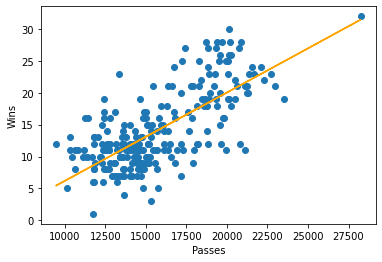

In [91]:
plt.scatter(X1,y1)
plt.plot(X1,regressor1.predict(X1),color='orange')
plt.xlabel('Passes')
plt.ylabel('Wins')
plt.show()

In [92]:
assert_is_not_none(X1)
assert_is_not_none(y1)
assert_is_not_none(regressor1)
assert_is_not_none(mae1)
assert_is_not_none(mse1)
assert_is_not_none(rmse1)
assert_is_not_none(y1_pred)
assert_greater(regressor1.score(X1_test, y1_test), 0)
assert_less_equal(regressor1.score(X1_test, y1_test), 1)

The final model we are going to build is the one centered around clean sheets.Let's see the how it fares.

In [93]:
y2 = stats['wins'].values.reshape(-1, 1)
X2 = stats['clean_sheet'].values.reshape(-1, 1)

In [94]:
print(stats['clean_sheet'].values)
print(stats['clean_sheet'].shape)

[16. 22. 20. 12.  6. 12. 13.  8. 14. 12.  9.  9. 13. 14.  7.  9. 10. 11.
  7.  9. 21. 21. 15. 18. 14.  9. 16.  8. 11.  8.  8.  7.  9.  8.  8. 12.
 12.  3.  7.  3. 24. 22. 20. 16. 13. 17. 10. 15. 13. 10. 12. 13.  7. 10.
  8.  9.  6.  8.  7.  7. 18. 19. 14. 13. 17. 11. 15. 11. 11. 13. 12. 14.
  7.  5.  8.  8.  3.  8.  7.  7. 15. 15. 18. 13. 14.  8.  9.  9.  7.  5.
 13.  2.  8. 14.  9.  5.  6.  7.  9.  5. 17. 20. 13. 14. 15. 10. 12. 11.
 12. 10.  3. 14.  9. 12.  8.  3.  7.  3.  9.  4. 13. 18. 14. 14.  9. 11.
 16.  8. 11.  8.  6. 10.  5. 10.  7. 12. 11.  5.  5.  7. 16. 10. 18. 17.
 15. 14. 13. 10. 15. 12.  9.  8. 14.  9. 10. 11.  5. 12.  7.  7. 17. 14.
 13. 11.  9. 14. 15. 13.  9.  7. 10.  9. 10. 16. 10.  8. 10.  6. 10. 13.
 15. 18. 16. 18. 13. 12. 11. 11. 10.  9.  9. 11.  7.  8. 10. 11.  8.  5.
  7.  6. 16. 17. 13. 12. 12. 17. 13. 10.  7.  9. 14.  8.  6. 10. 10. 11.
  7.  5.  6. 11. 18. 19. 16. 16. 17. 13. 12. 10.  9.  9.  6.  9.  9. 10.
 10. 10.  9.  8.  6. 10.]
(240,)


In [95]:
Seed = 42
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=Seed)

In [96]:
print(X2_train)

[[ 7.]
 [18.]
 [12.]
 [11.]
 [10.]
 [ 8.]
 [17.]
 [ 9.]
 [ 3.]
 [11.]
 [ 5.]
 [11.]
 [ 5.]
 [16.]
 [13.]
 [11.]
 [20.]
 [11.]
 [12.]
 [14.]
 [ 3.]
 [10.]
 [ 6.]
 [14.]
 [ 8.]
 [ 9.]
 [ 8.]
 [18.]
 [12.]
 [ 6.]
 [ 9.]
 [ 7.]
 [ 7.]
 [11.]
 [ 6.]
 [ 7.]
 [18.]
 [ 7.]
 [13.]
 [12.]
 [11.]
 [20.]
 [16.]
 [15.]
 [14.]
 [13.]
 [ 5.]
 [ 9.]
 [ 3.]
 [22.]
 [13.]
 [13.]
 [ 7.]
 [10.]
 [16.]
 [ 9.]
 [11.]
 [ 6.]
 [ 5.]
 [16.]
 [20.]
 [ 8.]
 [10.]
 [17.]
 [ 4.]
 [15.]
 [16.]
 [13.]
 [ 8.]
 [13.]
 [ 7.]
 [ 9.]
 [12.]
 [16.]
 [19.]
 [15.]
 [ 9.]
 [11.]
 [ 8.]
 [ 8.]
 [ 9.]
 [10.]
 [ 8.]
 [10.]
 [ 6.]
 [14.]
 [ 9.]
 [ 5.]
 [10.]
 [14.]
 [12.]
 [11.]
 [ 7.]
 [15.]
 [12.]
 [18.]
 [17.]
 [13.]
 [10.]
 [24.]
 [14.]
 [18.]
 [10.]
 [ 5.]
 [15.]
 [ 3.]
 [16.]
 [15.]
 [ 9.]
 [18.]
 [16.]
 [14.]
 [12.]
 [12.]
 [10.]
 [10.]
 [10.]
 [ 5.]
 [13.]
 [16.]
 [10.]
 [11.]
 [15.]
 [ 8.]
 [ 8.]
 [ 9.]
 [ 3.]
 [ 2.]
 [13.]
 [10.]
 [ 6.]
 [ 5.]
 [14.]
 [14.]
 [ 7.]
 [17.]
 [10.]
 [11.]
 [15.]
 [ 7.]
 [ 9.]
 [ 7.]
 [11.]

In [97]:
print(y2_train)

[[ 4.]
 [27.]
 [22.]
 [16.]
 [12.]
 [11.]
 [21.]
 [12.]
 [10.]
 [ 5.]
 [10.]
 [ 9.]
 [11.]
 [16.]
 [28.]
 [16.]
 [28.]
 [13.]
 [14.]
 [17.]
 [ 8.]
 [11.]
 [ 8.]
 [12.]
 [13.]
 [21.]
 [ 9.]
 [21.]
 [16.]
 [ 8.]
 [19.]
 [ 7.]
 [ 9.]
 [18.]
 [12.]
 [12.]
 [25.]
 [11.]
 [11.]
 [10.]
 [15.]
 [25.]
 [21.]
 [15.]
 [24.]
 [12.]
 [ 9.]
 [12.]
 [ 8.]
 [25.]
 [22.]
 [19.]
 [ 7.]
 [26.]
 [16.]
 [11.]
 [11.]
 [ 7.]
 [10.]
 [28.]
 [20.]
 [ 8.]
 [15.]
 [28.]
 [ 5.]
 [21.]
 [11.]
 [12.]
 [16.]
 [16.]
 [ 7.]
 [ 8.]
 [ 9.]
 [27.]
 [27.]
 [24.]
 [ 7.]
 [10.]
 [ 9.]
 [10.]
 [12.]
 [ 9.]
 [15.]
 [15.]
 [17.]
 [22.]
 [11.]
 [ 6.]
 [12.]
 [23.]
 [ 9.]
 [12.]
 [11.]
 [23.]
 [12.]
 [19.]
 [18.]
 [17.]
 [10.]
 [28.]
 [21.]
 [21.]
 [ 7.]
 [ 9.]
 [21.]
 [ 1.]
 [30.]
 [14.]
 [11.]
 [20.]
 [20.]
 [21.]
 [14.]
 [19.]
 [18.]
 [10.]
 [10.]
 [ 9.]
 [19.]
 [23.]
 [14.]
 [20.]
 [23.]
 [10.]
 [15.]
 [12.]
 [12.]
 [12.]
 [19.]
 [12.]
 [ 6.]
 [12.]
 [15.]
 [11.]
 [ 7.]
 [18.]
 [11.]
 [ 8.]
 [18.]
 [11.]
 [12.]
 [ 9.]
 [10.]

In [98]:
regressor2 = regressor
regressor2.fit(X2_train,y2_train)

LinearRegression()

In [99]:
print(regressor2.coef_)

[[1.10938078]]


In [100]:
print(regressor2.intercept_)

[2.20135236]


In [101]:
print(calc(regressor2.coef_,regressor2.intercept_,18))
regressor2.predict([[18]])

[[22.17020638]]


array([[22.17020638]])

In [102]:
y2_pred = regressor2.predict(X2_test)

In [103]:
actual_predicted2 = pd.DataFrame({'Actual': y2_test.squeeze(), 'Predicted': y2_pred.squeeze()})
print(actual_predicted2)

    Actual  Predicted
0     19.0  17.732683
1     16.0  16.623302
2     11.0  17.732683
3     13.0  13.295160
4     19.0  18.842064
5     11.0  13.295160
6     10.0  13.295160
7     13.0  12.185779
8     14.0  15.513922
9     24.0  21.060826
10    17.0  21.060826
11    17.0  16.623302
12    11.0  11.076399
13    15.0  12.185779
14    11.0  15.513922
15    11.0   8.857637
16    18.0  15.513922
17    10.0  12.185779
18    11.0  17.732683
19    16.0  14.404541
20    14.0  11.076399
21     5.0  12.185779
22     9.0  13.295160
23    11.0  11.076399
24     8.0  13.295160
25    13.0  12.185779
26    12.0  12.185779
27    26.0  21.060826
28     7.0  11.076399
29    10.0  12.185779
30    10.0   8.857637
31    12.0  12.185779
32    16.0  12.185779
33    19.0  19.951445
34     8.0   9.967018
35    13.0  16.623302
36    11.0   9.967018
37     9.0  12.185779
38     6.0   9.967018
39    10.0  11.076399
40    13.0  13.295160
41    11.0  12.185779
42    25.0  23.279587
43    10.0  13.295160
44     9.0

In [104]:
mae2 = mean_absolute_error(y2_test, y2_pred)
mse2 = mean_squared_error(y2_test, y2_pred)
rmse2 = np.sqrt(mse2)

In [105]:
print(f'Mean absolute error: {mae2:.2f}')
print(f'Mean squared error: {mse2:.2f}')
print(f'Root mean squared error: {rmse2:.2f}')

Mean absolute error: 2.33
Mean squared error: 8.81
Root mean squared error: 2.97


Wow! This model is closing in again and we have seen a root mean squared error below 3 for the first time. Not bad, starting off with a model with 4.05. Clean sheets looks like the winner!\
It predicts the wins with the most accuracy and it does give a glimmer of hope for the defensive teams/football.\
The single most important metric that we tested was clean sheets.\
An interesting regression that could be done is to see how total_pass or touches influences clean sheets.\
It may have some meaning considering the more you keep the ball the more likely you are to concede a goal.\
Let's check the R Squared.

In [106]:
regressor2.score(X2_test,y2_test)

0.5922225132346054

Decent results. Around 60% accuracy is not ideal but it still shows us that the model is dependable.\
It seems that given our data and the disadvantages that it has we still managed to produce a relatively good metric to predict wins - that is not goals. \
Let's plot the model in the scatter we did earlier.

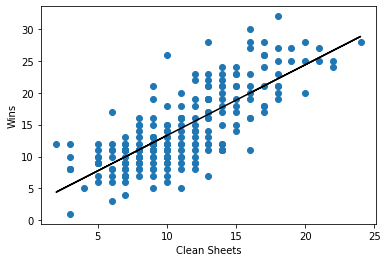

In [107]:
plt.scatter(X2,y2)
plt.plot(X2,regressor2.predict(X2),color='black')
plt.xlabel('Clean Sheets')
plt.ylabel('Wins')
plt.show()

In [108]:
assert_is_not_none(X2)
assert_is_not_none(y2)
assert_is_not_none(regressor2)
assert_is_not_none(mae2)
assert_is_not_none(mse2)
assert_is_not_none(rmse2)
assert_is_not_none(y2_pred)
assert_greater(regressor2.score(X2_test, y2_test), 0)
assert_less_equal(regressor2.score(X2_test, y2_test), 1)

# Conclusion

In conclusion, we cleaned the data, we found some interesting questions we asked and have answered and we plotted some interesting results to present visually.We found how accurately touches,passes and clean sheets can predict wins and therefore how important they should be to teams. Given the limits of our data and our linear regression model the results have been statisfactory. 

## Thank you for reading this notebook.